In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import cv2
import os

# Directory where your images are located
input_directory = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteopenia'
# Directory where you want to save the modified images
output_directory = '/kaggle/working/newinput'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Loop through the images in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith(".jpg"):  # Modify the file extension as needed
        # Load the image
        image_path = os.path.join(input_directory, filename)
        img = cv2.imread(image_path)

        # Zoom the image (resize)
        zoomed_img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

        # Flip the image horizontally
        flipped_img = cv2.flip(zoomed_img, 1)

        # Save the modified image
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, flipped_img)

print("Images have been processed and saved to the output directory.")


Images have been processed and saved to the output directory.


In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/working/'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [5]:
import os
import pandas as pd

healthy_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/normal',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Normal',
    r'/kaggle/input/osteoporosis/osteoporosis/normal'
]

osteopenia_dir = [ r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteopenia',
                  r'/kaggle/working/newinput', r'/kaggle/working/newinput']

osteoporosis_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Osteoporosis',
    r'/kaggle/input/osteoporosis/osteoporosis/osteoporosis'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteopenia_dir, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteopenia', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())


                                           filepaths   labels
0  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
1  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
2  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
3  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
4  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
labels
Osteoporosis    793
Healthy         780
Osteopenia      374
Name: count, dtype: int64


In [6]:
knee_osteoporosis_df.shape

(1947, 2)

In [7]:
train_images, test_images = train_test_split(knee_osteoporosis_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(knee_osteoporosis_df, test_size=0.2, random_state=42)

In [8]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(1557, 2)
(585, 2)
(390, 2)
(1362, 2)


In [9]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1557 validated image filenames belonging to 3 classes.
Found 585 validated image filenames belonging to 3 classes.
Found 390 validated image filenames belonging to 3 classes.


In [10]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteopenia', 'Osteoporosis']


In [11]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

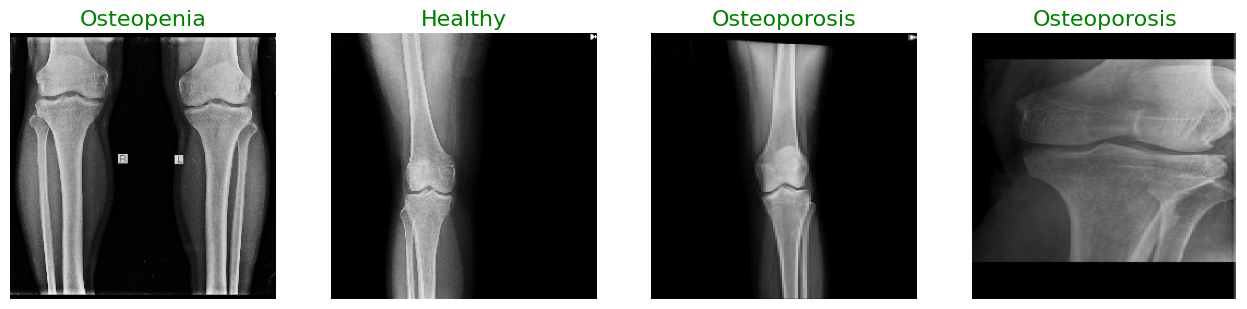

In [12]:
show_knee_images(train)

In [13]:
# from keras.layers import Input, Conv2D, MaxPooling2D
# from keras.layers import Dense, Flatten
# from keras.models import Model
# import tensorflow as tf

# _input = Input((224, 224, 3))

# conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(_input)
# conv2 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(conv1)
# pool1 = MaxPooling2D((2, 2))(conv2)

# conv3 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(pool1)
# conv4 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(conv3)
# pool2 = MaxPooling2D((2, 2))(conv4)

# conv5 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(pool2)
# conv6 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(conv5)
# conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(conv6)
# pool3 = MaxPooling2D((2, 2))(conv7)

# conv8 = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(pool3)
# conv9 = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(conv8)
# conv10 = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(conv9)
# pool4 = MaxPooling2D((2, 2))(conv10)

# conv11 = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(pool4)
# conv12 = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(conv11)
# conv13 = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(conv12)
# pool5 = MaxPooling2D((2, 2))(conv13)

# flat = Flatten()(pool5)
# dense1 = Dense(4096, activation="relu")(flat)
# dense2 = Dense(4096, activation="relu")(dense1)
# output = Dense(3, activation="softmax")(dense2)

# vgg16_model = Model(inputs=_input, outputs=output)

# vgg16_model.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.optimizers.SGD(learning_rate=0.001),
#     metrics=['accuracy']
# )

# vgg16_model.summary()  # Corrected model summary call



In [14]:
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
import tensorflow as tf

vgg16_weights = '../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load the pre-trained VGG16 model with built-in weights
base_model = VGG16(weights=vgg16_weights, include_top=False, input_shape=(224, 224, 3))

# Add your custom layers on top of VGG16
x = base_model.output

# Add your custom layers here
x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)

x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)
output = Dense(3, activation="softmax")(x)

# Create the custom model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# # Load and preprocess your training and validation data (train and val)

# history = vgg16_model.fit(train, epochs=10, validation_data=val,verbose=1)
history = model.fit(train, epochs=20, validation_data=val, verbose=1)


Epoch 1/20
390/390 [==============================] - 87s 198ms/step - loss: 1.0849 - accuracy: 0.4104 - val_loss: 1.0674 - val_accuracy: 0.6026
Epoch 2/20
390/390 [==============================] - 71s 181ms/step - loss: 1.0622 - accuracy: 0.4284 - val_loss: 1.0403 - val_accuracy: 0.5359
Epoch 3/20
390/390 [==============================] - 67s 172ms/step - loss: 1.0357 - accuracy: 0.4335 - val_loss: 0.9977 - val_accuracy: 0.4103
Epoch 4/20
390/390 [==============================] - 70s 180ms/step - loss: 0.8982 - accuracy: 0.5485 - val_loss: 0.7772 - val_accuracy: 0.5795
Epoch 5/20
390/390 [==============================] - 67s 172ms/step - loss: 0.7687 - accuracy: 0.5941 - val_loss: 0.7293 - val_accuracy: 0.6103
Epoch 6/20
390/390 [==============================] - 70s 179ms/step - loss: 0.7396 - accuracy: 0.6095 - val_loss: 0.7236 - val_accuracy: 0.6154
Epoch 7/20
390/390 [==============================] - 68s 174ms/step - loss: 0.7075 - accuracy: 0.6538 - val_loss: 0.6925 - val_ac

In [16]:
# history = vgg16_model.fit(train, epochs=10, validation_data=val,verbose=1)

In [17]:
# history = vgg16_model.fit(train, epochs=10, validation_data=val,verbose=1)

In [18]:
model.evaluate(test, verbose=1)

147/147 [==============================] - 15s 99ms/step - loss: 0.2748 - accuracy: 0.9077


[0.2748437523841858, 0.9076923131942749]

In [30]:
model.save("Osteoporosis_Model_Multi1.h5")

In [31]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

147/147 [==============================] - 16s 105ms/step


In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

     Healthy       0.97      0.90      0.93       238
  Osteopenia       0.86      0.86      0.86       111
Osteoporosis       0.87      0.94      0.91       236

    accuracy                           0.91       585
   macro avg       0.90      0.90      0.90       585
weighted avg       0.91      0.91      0.91       585

Accuracy of the Model: 90.8%


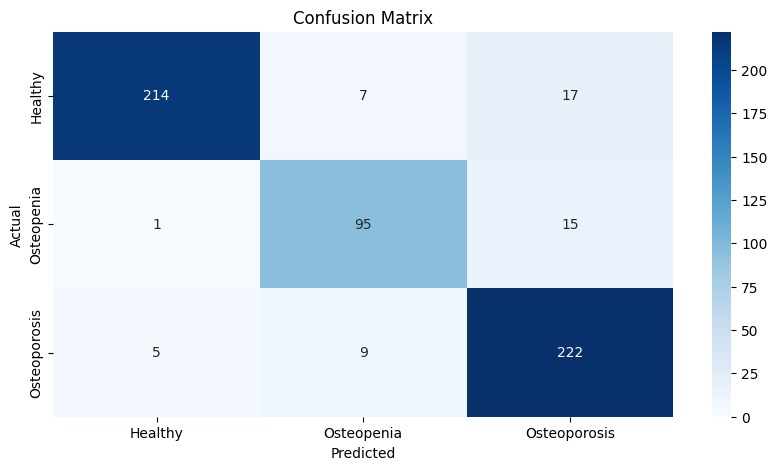

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Healthy', 'Osteopenia','Osteoporosis']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [34]:
import matplotlib.pyplot as plt

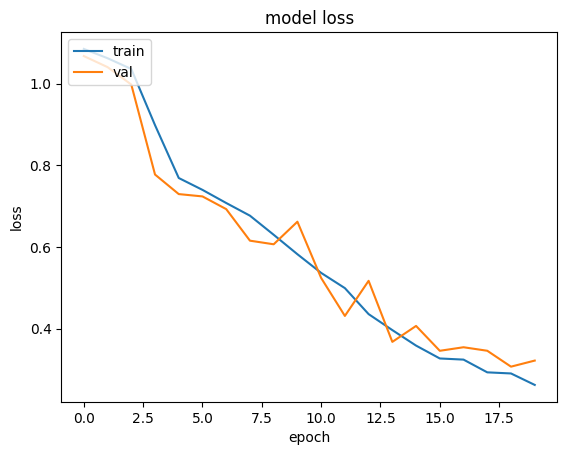

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

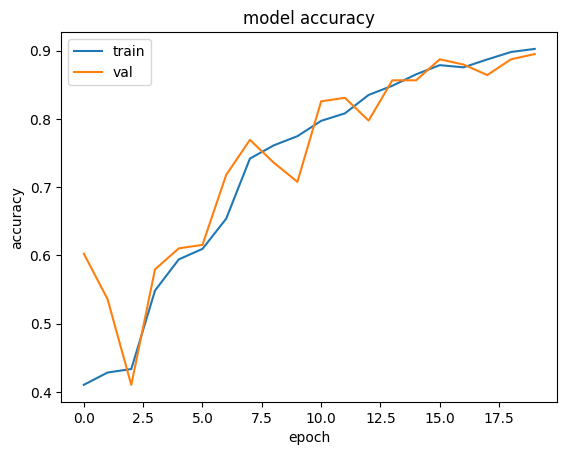

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [37]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('Osteoporosis_Model_Multi1.h5')


In [38]:
import os
image_path = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis/OS14.jpg'



In [39]:
import cv2
import numpy as np

def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)  # Read the image
    image_resized = cv2.resize(image, target_size)  # Resize the image
    image_normalized = image_resized / 255.0  # Normalize pixel values
    return np.expand_dims(image_normalized, axis=0)  # Add batch dimension


In [40]:
image_path = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis/OS14.jpg'

try:
    # Preprocess the image
    image_ready = preprocess_image(image_path)
    
    # Run prediction
    prediction = model.predict(image_ready)
    
    # Store the result
    results = [{'Filename': os.path.basename(image_path), 'Prediction': prediction[0]}]
    print(results)
except Exception as e:
    print(f"Error processing the image: {e}")


1/1 [==============================] - 1s 812ms/step
[{'Filename': 'OS14.jpg', 'Prediction': array([0.05683609, 0.8472547 , 0.09590922], dtype=float32)}]


1/1 [==============================] - 0s 20ms/step


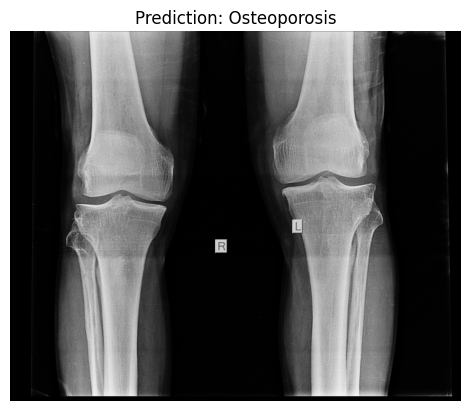

In [41]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Define class labels (adjust based on your model's classes)
class_labels = ["Healthy", "Osteoporosis"]  # Modify as needed

# Attempt to read the image
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Unable to load the image at {image_path}")
else:
    # Convert BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Preprocess the image (if not already done in the pipeline)
    image_ready = preprocess_image(image_path)  # Ensure this function is defined

    # Run the prediction
    prediction = model.predict(image_ready)

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)  # Use argmax for multiclass models
    predicted_class = class_labels[predicted_class_index]

    # Display the image with the predicted class
    plt.imshow(image_rgb)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()


In [42]:
import pandas as pd

# Example: Store filename and prediction
results = [{'Filename': 'image.jpg', 'Prediction': prediction[0][0]}]  # Adjust as per model output
results_df = pd.DataFrame(results)
results_df.to_csv('/kaggle/working/predictions.csv', index=False)

In [43]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter


In [52]:
image_dir = "/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis"  # Replace with your dataset path
classes = os.listdir(image_dir)
print(f"Classes in Dataset: {classes}")


Classes in Dataset: ['osteoporosis']


In [53]:
# Count the number of images in each class
class_counts = {cls: len(os.listdir(os.path.join(image_dir, cls))) for cls in classes}
print(f"Number of Images per Class:\n{class_counts}")


Number of Images per Class:
{'osteoporosis': 186}


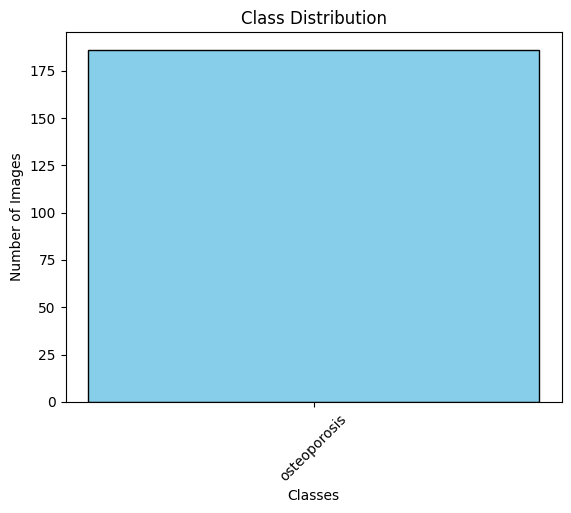

In [54]:
# Plot the distribution of images per class
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue', edgecolor='black')
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


In [55]:
image_shapes = []
aspect_ratios = []

for cls in classes:
    class_path = os.path.join(image_dir, cls)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        image_shapes.append(img.size)  # (width, height)
        aspect_ratios.append(img.size[0] / img.size[1])  # width / height

# Analyze common sizes and aspect ratios
shape_counts = Counter(image_shapes)
print(f"Most Common Image Shapes:\n{shape_counts}")


Most Common Image Shapes:
Counter({(2430, 1994): 60, (514, 1024): 9, (492, 1024): 6, (506, 1024): 3, (2430, 1910): 2, (486, 1024): 2, (524, 1024): 2, (482, 1024): 2, (538, 1024): 2, (518, 1024): 2, (534, 1024): 2, (2378, 1994): 2, (515, 1024): 2, (464, 1024): 2, (498, 1024): 2, (1328, 2176): 2, (472, 1024): 2, (448, 1024): 2, (1301, 1992): 2, (510, 1024): 1, (556, 1024): 1, (1224, 1992): 1, (1176, 1992): 1, (458, 1024): 1, (1248, 2180): 1, (1288, 2180): 1, (1201, 1993): 1, (540, 1024): 1, (486, 956): 1, (1240, 1992): 1, (1076, 2660): 1, (1036, 2660): 1, (534, 964): 1, (524, 986): 1, (438, 968): 1, (2402, 1994): 1, (504, 1024): 1, (1105, 2660): 1, (370, 948): 1, (496, 1024): 1, (444, 1024): 1, (1411, 2180): 1, (2430, 1958): 1, (1357, 1992): 1, (1221, 1992): 1, (470, 1024): 1, (475, 1024): 1, (1196, 1992): 1, (1451, 2179): 1, (1187, 2656): 1, (1132, 1992): 1, (476, 1024): 1, (460, 1024): 1, (1144, 1992): 1, (508, 1024): 1, (1328, 2180): 1, (464, 940): 1, (532, 1024): 1, (1363, 2180): 1, 

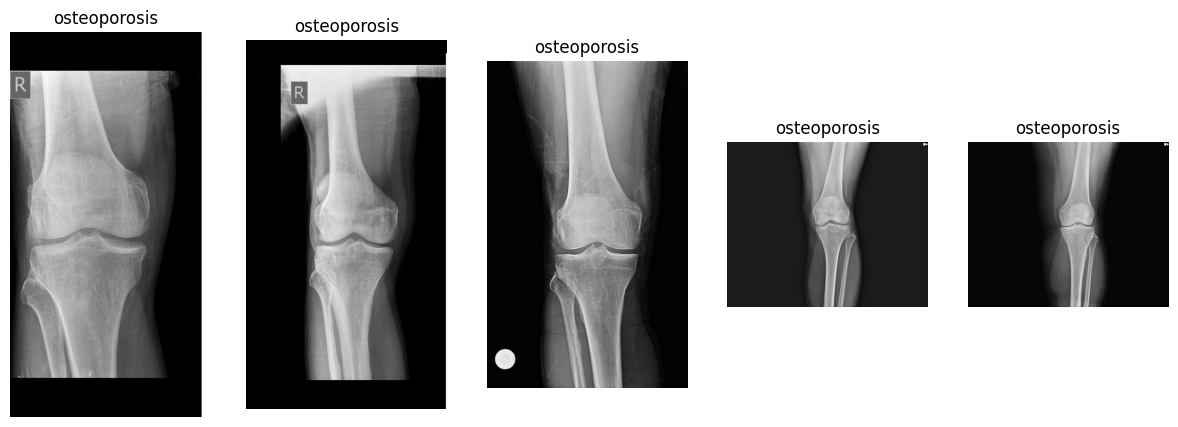

In [56]:
# Display a few images from each class
for cls in classes:
    class_path = os.path.join(image_dir, cls)
    sample_images = os.listdir(class_path)[:5]  # Display 5 images per class
    
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, 5, i+1)
        plt.imshow(img_rgb)
        plt.title(cls)
        plt.axis("off")
    plt.show()
